# Who or What Extracts Keywords Better? 

In [273]:
# import dependencies 
import pandas as pd
import re
from deep_translator import GoogleTranslator
import yake
from multi_rake import Rake
from summa import keywords
from keybert import KeyBERT
import plotly.graph_objects as go
from wordcloud import WordCloud
from IPython.display import HTML
import matplotlib.pyplot as plt

#expand column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


## Instructions
Each block of the practical assignment has discussion questions and required actions, as well as cells, where you can write answers for the questions

####  <span style="color:green">??? Questions are marked in green </span>
####  <span style="color:DarkRed">!!! Action needed: Required actions are marked in dark red</span>

 <figure>
<img src="./static/human-vs-robots.jpeg" style="width:100%">
<figcaption align = "center"> Image Credit: depositphotos.com </figcaption>
</figure>

## What will we do today?
**Intro**  \
What data are we using?\
Description of the dataset <br>
Data exploration <br>
**Part One** \
What are 🔑words? How do we find them? \
How long would that take?
**Part Two** \
How does computer detect keywords?
How long would that take?

## Architektenlexikon
Data of the publication by Isabelle Rucki, Dorothee Huber (eds). Architektenlexikon der Schweiz 19./20. Jahrhundert, Basel/Boston/Berlin 1998.

In [172]:
file_path = "./texts/architektenlexikon.txt"

## First some data exploration

Let's have a look at the text and try to find some structure within it. 
####  <span style="color:green">??? How are the entries separated from each other? What information do entries include? </span>

In [173]:
with open(file_path, "r") as f:
    text = ""
    for i, line in enumerate(f):
        if i >= 500:
            break
        text += line
    print(text)

Aberle, Anton
*14.11.1876 in Möhringen (D), 115.8.1953 in Thusis GR, Architekt.
Aufgewachsen im südlichen Schwarzwald, be- suchte der Bauernsohn nach einer Zimmermannslehre die Karlsruher Bauhochschule. Im Anschluß an sein Studium fand er 1904 eine Anstellung bei Curjel und Moser (Robert -► Curjel,
Karl -► Moser) in Karlsruhe und wurde mit der Bauleitung eines Hotels auf dem Feldberg im Schwarzwald beauftragt. 1906kam A als Bauleiter der Karlsruher Architekten nach St. Gallen.
Hier entstanden unter seiner Regie die bedeutenden Stickereigeschäftshäuser Pacific an der Schreinerstraße (1906/07, zugleich Geschäftssitz der St. Galler Zweigstelle von «Curjel und Moser» und Wilson an der Teufenerstraße (1907/08).
1909 machte sich A selbständig. Zwei Jahre später erhielt er das Bürgerrecht seiner Ostschweizer Wahlheimat und heiratete die Tochter eines Fensterfabrikanten. 1910-20 erstellte er verschiedene Geschäftshäuser und Stickereifabriken in der Stadt St. Gallen, in Amriswil und im vorarlbe

## Making text more human-readable, structuring text

We are going to use a type of data structure called <b>dataframe</b>. \
<b>Dataframe</b> is a data structure that organizes data into a 2-dimensional table of rows and columns, much like a spreadsheet. DataFrames are one of the most common data structures used in modern data analytics because they are a flexible and intuitive way of storing and working with data.

So, ultimately, <b>dataframe</b> is a huge table or a spreadsheet, which can be accessed computationally.


In [24]:
split_line ="############### ENTRY BOUNDARY ###############"

def create_entries(file_path, split_line):
    """
    Reads a text file and creates a Pandas DataFrame based on the split line.

    Parameters:
    file_path (str): The path to the text file.
    split_line (str): The split line to use for separating the text. 
    Returns:
    pd.DataFrame: The Pandas DataFrame containing the name and biography columns.
    """
    # Read the text file
    with open(file_path, "r") as f:
        text = f.read()

    # Split the text into entries based on the split line
    entries = text.split(split_line)

    # Create a list to hold the data
    data = []

    # Loop through each entry
    for entry in entries:
        # Split the entry into name and biography
        lines = entry.strip().split("\n")
        name = lines[0]
        biography = "\n".join(lines[1:]).replace("\n", " ")

        # Add the data to the list
        data.append([name, biography])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=["architect_name", "architect_biography"])

    return df

In [106]:
architects_df = create_entries(file_path, split_line)
architects_df

architect_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Let's see the list of names in the Lexicon.

In [107]:
for i, name in enumerate(architects_df.architect_name):
    print(f"Index: {i}, Name: {name}")

Index: 0, Name: Aberle, Anton
Index: 1, Name: ACAU, Atelier Coopératif d’Architecture et d’Urbanisme
Index: 2, Name: Adamini, Antonio
Index: 3, Name: Addor, Georges
Index: 4, Name: Albertolli, (Giuseppe) Giocondo
Index: 5, Name: Aider, Michael
Index: 6, Name: Allemand, Louis-Jules
Index: 7, Name: Altherr, Alfred
Index: 8, Name: Ammann, Gustav
Index: 9, Name: Ammann, Othmar Hermann
Index: 10, Name: Ammann und Baumann
Index: 11, Name: Amsler, Arnold und Vrendli
Index: 12, Name: Anderegg, Ernst E.
Index: 13, Name: André, Abraham-Gaspard
Index: 14, Name: Andry, Flurin
Index: 15, Name: Annen, Michael
Index: 16, Name: Antoniol und Huber
Index: 17, Name: Appia, Adolphe
Index: 18, Name: ARB Arbeitsgruppe Bern
Index: 19, Name: Archico
Index: 20, Name: Arcoop
Index: 21, Name: Arioli, Richard
Index: 22, Name: Artaria, Paul
Index: 23, Name: ASS Architectes (Annen, Siebold, Siegle Architekten)
Index: 24, Name: Atelier 5
Index: 25, Name: Atelier Coopératif d’Architecture et d’Urbanisme
Index: 26, Na

### Total number of entries in the dataframe
How many entries do we have in total?

In [109]:
print("There are", len(architects_df), "in total")

There are 825 in total


## Find 20 longest biographies
Let's see what are the longest biographies?

In [110]:
sorted_df = architects_df.assign(bio_len=architects_df['architect_biography'].str.len()).sort_values('bio_len', ascending=False)

# Get the 20 rows with the longest biography text and print the "Name" and "Biography" columns
longest_biographies = sorted_df.nlargest(20, 'bio_len')
for index, row in longest_biographies.iterrows():
    print(f"Name: {row['architect_name']}")
    print(f"Biography: {row['architect_biography']}\n")

Name: Atelier Stern und Partner (asp)
Biography: Stern, Christian, *14.10.1935 in Zürich, Landschaftsarchitekt Badeja. P. J. Edmund, *3.2.1942 in Petersdorf (Schlesien, heute Polen). Landschaftsarchitekt. Engel, Gerwin, *29.3.1943 in Berlin, Landschaftsarchitekt. Holzhausen, Klaus, *18.2.1937 in Krefeld (I)), Landschaftsarchitekt. Weber, Hans-Ulrich, *21.1.1942 in St. Gallen, Landschaftsarchitekt. Bürogründung 1968 durch Christian Stern in Zürich, seit 1974 gemeinsame Führung mit Edmund Badeja, Gerwin Engel, Klaus Holzhausen (bis 1990) und Hans-Ulrich Weber, Landschaftsarchitekten. In den ersten Jahren realisierten asp Friedhöfe und zahlreiche Freiräume zu Siedlungen und Schulhäusern in den rasch wachsenden Zürcher Agglomerationsgemeinden. Die Werke erfüllen aktuelle Bedürfnisse in der rationellen Bewirtschaftung und der Pflege. Sie animieren zur Aneignung, stehen für Offenheit und Zwanglosigkeit. Später wirkte das Büro als Trendmacher bis zum Durchbruch der in der Fachpresse sehr umst

## Interesting architects

Here is the list of architects of interest provided by a domain specialist.

1. Le Corbusier
2. Rudolf Olgiati
3. Lisbeth Sachs
4. Atelier 5
5. Luigi Snozzi
6. Flora Ruchat-Roncati
7. Mario Botta
8. Peter Zumthor
9. Bernard Tschumi
10. Herzog & de Meuron

In [150]:
interesting_architects = ["Le Corbusier", "Olgiati", "Sachs", "Atelier 5", "Snozzi", "Ruchat-Roncati", "Botta", "Zumthor", "Tschumi, Bernard ", "Herzog und de Meuron" ]
for i, item in enumerate(interesting_architects):
    print(i,item)

0 Le Corbusier
1 Olgiati
2 Sachs
3 Atelier 5
4 Snozzi
5 Ruchat-Roncati
6 Botta
7 Zumthor
8 Tschumi, Bernard 
9 Herzog und de Meuron


####  <span style="color:DarkRed">!!! Action needed! </span> 
Insert the name of one of the architects from the list above, after the variable "architect_of_interest"  

In [152]:
architect_of_interest = "Zweifel, Jakob"
column_name = "architect_name"
interesting_biography = architects_df[architects_df[column_name].str.contains(architect_of_interest)]
interesting_biography["architect_biography"]

823    *29.9.1921 in Wil SG, Architekt. Nach der Kantonsschule in St. Gallen begann Z. das Studium der Kultur- und Vermessungstechnik an der ETHZ, wechselte dann 1941 in die Abteilung für Architektur (1946 Diplom bei Hans -> Hofmann) und war danach während dreier Jahre Assistent bei William -► Dunkel. 1949 eröffnete Z. ein eigenes Architekturbüro, zunächst in Glarus, dann in Zürich und 1971 auch in Lausanne. Diese Erweiterungen waren begleitet vom Beizug von Partnern, 1957 Heinrich Strickler in Zürich, Willi Marti und später Willy Leins in Glarus. Zu den langjährigen Partnern Strickler, Hans Ulrich Glauser und Benjamin Pfister trat in Lausanne 1986 Nicolas Joye in die Bürogemeinschaft ein. Z. war Mitglied des BSA und leitete 1962 - 67 die Ortsgruppe Zürich. 1963-95 war er Obmann der Glamerischen Vereinigung für Heimatschutz. Den Ruf der Qualität hat sich Z. hauptsächlich in Wettbewerben erworben. Zu seinem Selbstverständnis als Architekt gehört dessen Rolle als die eines Leaders: In de

## In case you want to find a biography by index number: 

In [153]:
#interesting_biography = architects_df.loc[29]
#print(f"Name: {interesting_biography['architect_name']}")
#print(f"Biography: {interesting_biography['architect_biography']}")

## Let's also translate our text into English:

In [155]:
def translate_text(text, target_language='en'):
    # Set the maximum number of characters per request
    max_chars = 4000
    
    # Split the text into chunks
    chunks = [text[i:i+max_chars] for i in range(0, len(text), max_chars)]
    
    # Translate each chunk separately and concatenate the results
    translated_text = ""
    for chunk in chunks:
        translated_chunk = GoogleTranslator(source='auto', target=target_language).translate(chunk)
        translated_text += translated_chunk
    
    return translated_text
original_entry = str(interesting_biography['architect_biography'])
translated_entry = translate_text(original_entry)
translated_entry

'823 *29.9.1921 in Wil SG, architect. After the canton school in St. Gallen, Z. began studying cultural and surveying technology at the ETHZ, then switched to the department of architecture in 1941 (1946 diploma with Hans -> Hofmann) and was then an assistant to William -► Dunkel for three years . In 1949 Z. opened his own architecture office, first in Glarus, then in Zurich and in 1971 also in Lausanne. These expansions were accompanied by the involvement of partners, 1957 Heinrich Strickler in Zurich, Willi Marti and later Willy Leins in Glarus. In 1986 in Lausanne, Nicolas Joye joined the long-term partners Strickler, Hans Ulrich Glauser and Benjamin Pfister. Z. was a member of the BSA and headed the Zurich local group from 1962-67. 1963-95 he was Chairman of the Glamer Association for Homeland Security. Z. has earned its reputation for quality mainly in competitions. His self-image as an architect includes his role as a leader: in teamwork with his partners, he has achieved the qua

## Note that we have two types of text - "original_entry" and "translated_entry". This will be important when we extract keywords computationally 

## And now let's get down to work!  Let us choose keywords from the biography by hand
We will need to have <b>10</b> keywords for each biography.
And I will time our process to see how long it will take us. 

####  <span style="color:DarkRed">!!! Action needed! </span> 
Read the text of the biography, find 10 keywords and write them down into the list of <b>"keywords_by_human"</b>. For formatting follow the example list of <b>"keywords_example"</b>

In [300]:
#example of a list of keywords
keywords_example = ["city", "shell design", "building", "Kultur", "Zurich", "architektur", "Lausanne", "Studium der Kultur", "ortsgruppe zürich", "strickler" ]
keywords_by_human = [""]
keywords_by_human

['']

## Extracting keywords computationally: YAKE - yet another keywords' extractor

####  <span style="color:DarkRed">!!! Action needed! </span> 
Depending on what entry you want to use, change "original_entry" to "translated_entry" in the last line of the next cell.

In [217]:
%%time
def yake_keywords_no_stopwords(text):
    kw_extractor = yake.KeywordExtractor(top=10)
    keywords = kw_extractor.extract_keywords(text)
    return keywords
yake_keywords_no_stopwords(original_entry)

CPU times: user 71.5 ms, sys: 2.16 ms, total: 73.6 ms
Wall time: 72.5 ms


[('und', 0.021668743942017607),
 ('Jahre Assistent bei', 0.025003559595996327),
 ('der', 0.026058393110844576),
 ('Lausanne', 0.027843624406279587),
 ('die', 0.028994488864071726),
 ('Studium der Kultur', 0.03179111300315057),
 ('dreier Jahre Assistent', 0.03368390924113431),
 ('Zürich', 0.036173135668487406),
 ('Hans Ulrich Glauser', 0.036973043511164864),
 ('Diplom bei Hans', 0.03919613692908183)]

####  <span style="color:green"> ??? What can we say about the most frequent keywords? </span> 

#### What are stopwords?
<b> Stop words </b> are highly occurring words in the document and we don't need those words to understand the document better since they do not add any meaningful information.

In [219]:
stopwords_de = [
    'aber', 'als', 'am', 'an', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'dadurch', 'daher', 'darum', 
    'das', 'daß', 'dass', 'dein', 'deine', 'dem', 'den', 'der', 'des', 'dessen', 'deshalb', 'die', 'dies', 'dieser', 
    'dieses', 'doch', 'dort', 'du', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'er', 'es', 'euer', 
    'eure', 'für', 'hatte', 'hatten', 'hattest', 'hattet', 'hier', 'hinter', 'ich', 'ihr', 'ihre', 'im', 'in', 'ist', 
    'ja', 'jede', 'jedem', 'jeden', 'jeder', 'jedes', 'jener', 'jenes', 'jetzt', 'kann', 'kannst', 'können', 'könnt', 
    'machen', 'mein', 'meine', 'mit', 'muß', 'mußt', 'musst', 'müssen', 'müßt', 'nach', 'nachdem', 'nein', 'nicht', 
    'nun', 'oder', 'seid', 'sein', 'seine', 'sich', 'sie', 'sind', 'soll', 'sollen', 'sollst', 'sollt', 'sonst', 
    'soweit', 'sowie', 'und', 'unser', 'unsere', 'unter', 'vom', 'von', 'vor', 'wann', 'warum', 'was', 'weiter', 
    'weitere', 'wenn', 'wer', 'werde', 'werden', 'werdet', 'weshalb', 'wie', 'wieder', 'wieso', 'wir', 'wird', 
    'wirst', 'wo', 'woher', 'wohin', 'zu', 'zum', 'zur', 'über'
]

stopwords_en = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
    "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
    'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
    'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
    'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
    'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
    'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
    "wouldn't"
]


### Now let's see what changes if we are eliminating stopwords

####  <span style="color:DarkRed">!!! Action needed! </span> 
Depending on what entry you want to use, change "original_entry" to "translated_entry" in the last line of the next cell. Also, make sure to switch to "stopwords_en" in case you are working with the translated entry.

In [278]:
%%time
def yake_keywords_with_stopwords(text):
    kw_extractor = yake.KeywordExtractor(top=10, stopwords = stopwords_de)
    keywords = kw_extractor.extract_keywords(text)
    return keywords
keywords_extracted_with_yake = yake_keywords_with_stopwords(original_entry)
keywords_extracted_with_yake

CPU times: user 81.3 ms, sys: 2.22 ms, total: 83.5 ms
Wall time: 83 ms


[('dreier Jahre Assistent', 0.017375554906967215),
 ('Hans Ulrich Glauser', 0.020822129978082304),
 ('Lausanne', 0.02140875557728158),
 ('Zürich', 0.029250485426471327),
 ('Studium der Kultur', 0.03554223955296607),
 ('Jahre Assistent', 0.03716057422728487),
 ('während dreier Jahre', 0.04220216649988817),
 ('langjährigen Partnern Strickler', 0.04725549260686895),
 ('Hans Ulrich', 0.05053654311364747),
 ('Glarus', 0.05515146500344246)]

In [279]:
keywords_extracted_with_yake_values = [t[0] for t in keywords_extracted_with_yake]
keywords_extracted_with_yake_values

['dreier Jahre Assistent',
 'Hans Ulrich Glauser',
 'Lausanne',
 'Zürich',
 'Studium der Kultur',
 'Jahre Assistent',
 'während dreier Jahre',
 'langjährigen Partnern Strickler',
 'Hans Ulrich',
 'Glarus']

####  <span style="color:DarkRed">!!! Action needed! </span> 

### Let's now look at famous BERT models:

In [249]:
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

In [254]:
%%time
def keywords_bert(text, stopwords_bert):
    keywords = kw_model.extract_keywords(text,

                                     keyphrase_ngram_range=(0, 2), 

                                     stop_words=stopwords_bert, 

                                     highlight=False,

                                     top_n=10)

    keywords_list= list(dict(keywords).keys())
    return(keywords_list)
keyword_extracted_with_bert = keywords_bert(original_entry, stopwords_de)
keyword_extracted_with_bert

CPU times: user 4.49 s, sys: 279 ms, total: 4.77 s
Wall time: 588 ms


['zürich 1963',
 'zürich 1971',
 'strickler zürich',
 'zürich schwestemhochhausdes',
 'erbracht architektonischer',
 'schwesternhauses zürich',
 'architektonischer weg',
 'architekt kantonsschule',
 'ortsgruppe zürich',
 'architektur 1946']

In [306]:
list1 = keywords_example
list2 = keywords_extracted_with_yake_values
list3 = keyword_extracted_with_bert
common_keywords = [keyword for keyword in list1 + list2 + list3 
                   if any(keyword.find(other_keyword) != -1 or other_keyword.find(keyword) != -1
                          for other_keyword in list1 + list2 + list3 )]

print(common_keywords)

['city', 'shell design', 'building', 'Kultur', 'Zurich', 'architektur', 'Lausanne', 'Studium der Kultur', 'ortsgruppe zürich', 'strickler', 'dreier Jahre Assistent', 'Hans Ulrich Glauser', 'Lausanne', 'Zürich', 'Studium der Kultur', 'Jahre Assistent', 'während dreier Jahre', 'langjährigen Partnern Strickler', 'Hans Ulrich', 'Glarus', 'zürich 1963', 'zürich 1971', 'strickler zürich', 'zürich schwestemhochhausdes', 'erbracht architektonischer', 'schwesternhauses zürich', 'architektonischer weg', 'architekt kantonsschule', 'ortsgruppe zürich', 'architektur 1946']


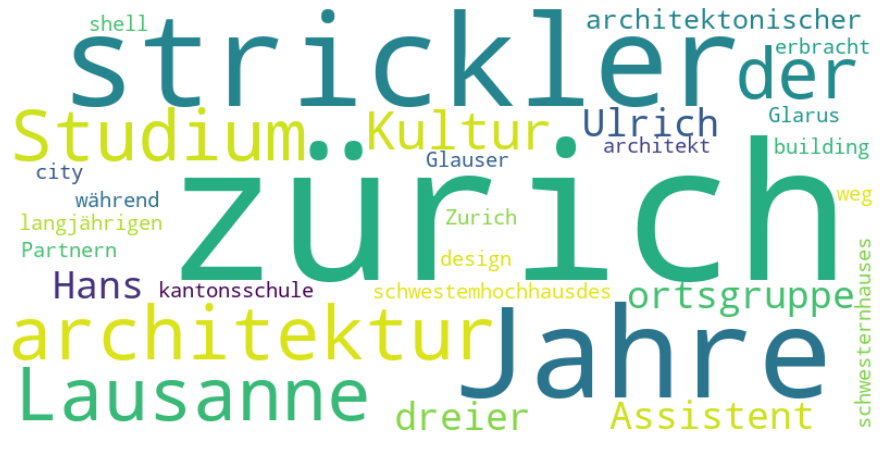

In [288]:
def plot_keywords_word_cloud(keywords1, keywords2, keywords3):
    # Combine all keywords into a single list
    all_keywords = keywords1 + keywords2 + keywords3

# Create a WordCloud
    wc = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(all_keywords))

# Plot the WordCloud
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_keywords_word_cloud(keywords_example,keywords_extracted_with_yake_values,keyword_extracted_with_bert)
